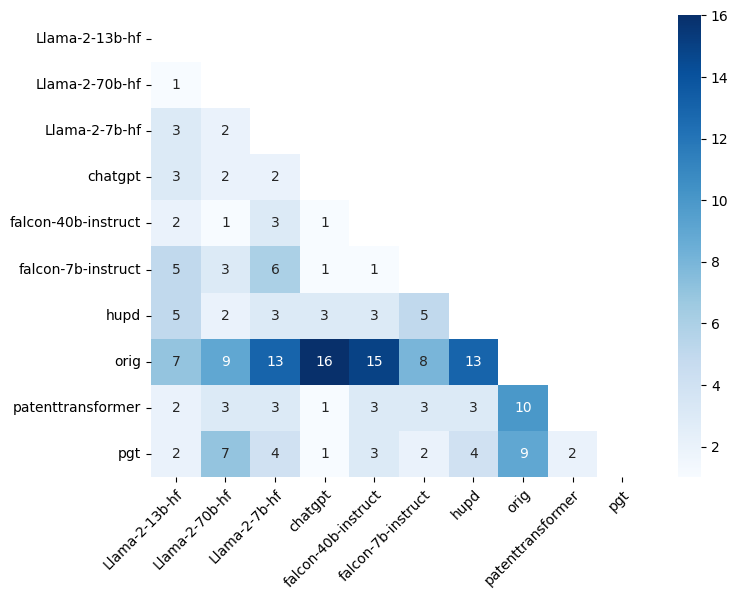

In [1]:
import json
import numpy as np
from collections import defaultdict


with open('./annotations/final_c2a.json') as f:  annotations = json.load(f)
with open('./preprocessed_for_annotation/selected_pairs_c2a.jsonl') as f:  model_info = [json.loads(line) for line in f]

# get model information from selected pairs
model_pairs = []
for model_selection in model_info:
    selections = list(model_selection.values())[0]
    assert len(selections) == 2
    for pair in selections:
        model_pairs.append(pair)

assert len(annotations) == len(model_pairs) # once finished, the length should be the same
model_pairs_annotated = model_pairs[:len(annotations)]


# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in model_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)


# create matrix of model pairs
model_names = list(model_freq.keys())
model_names = sorted(model_names)
count_pairs = np.zeros((len(model_names), len(model_names)))
for pair in model_pairs:
    model1, model2 = pair
    
    count_pairs[model_names.index(model1), model_names.index(model2)] += 1
    count_pairs[model_names.index(model2), model_names.index(model1)] += 1


# plot the heatmap of model pairs, only show upper triangle of the matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(count_pairs, columns=model_names, index=model_names)
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt='.0f', cmap='Blues')
# Adjust x-tick labels
plt.xticks(np.arange(len(model_names))+0.5, model_names, rotation=45, ha="right", rotation_mode='anchor')

plt.savefig('./figures/c2a_model1_model2', dpi=300)

## visualization of human annotations

In [2]:
with open('./annotations/final_c2a.json') as f:  annotated_data = json.load(f)

annotations = []
for annot in annotated_data:
    assert len(annot) > 0
    data_line = [annot["input_claim"], annot["output1"], annot["output2"]]
    preference = annot["comparison"][0]["selected"] if "comparison" in annot and "selected" in annot["comparison"][0] else "draw"

    errors = {}
    if "dimension1" not in annot:
        errors["dimension1"] = []
    elif "choices" in annot["dimension1"]:
        errors["dimension1"] = annot["dimension1"]["choices"]
    else:
        errors["dimension1"] = [annot["dimension1"]]

    if "dimension2" not in annot:
        errors["dimension2"] = []
    elif "choices" in annot["dimension2"]:
        errors["dimension2"] = annot["dimension2"]["choices"]
    else:
        errors["dimension2"] = [annot["dimension2"]]

    # annotations.append({"data": data_line, "preference": preference, "errors": errors})
    annotations.append({"preference": preference, "errors": errors})

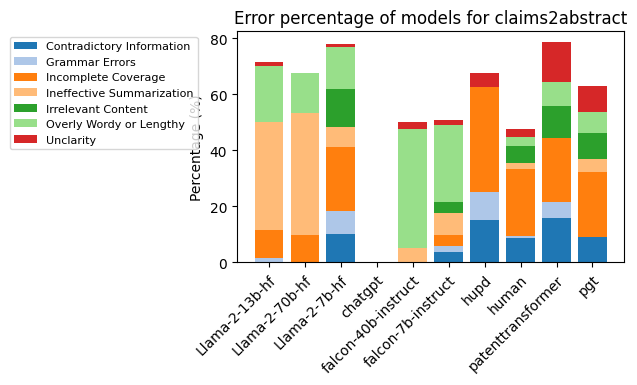

In [3]:
from collections import defaultdict

# get all error types from annotations, and initialize the frequency of each error to 0
default_errors = []
for annotation in annotations:
    for error in annotation["errors"]["dimension1"] + annotation["errors"]["dimension2"]:
        default_errors.append(error)
default_errors = sorted(set(default_errors)) + ["Correct"]
default_errors = {error.split("(")[0].strip(): 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True

    for error in annot["errors"]["dimension1"]:
        errors[model1][error.split("(")[0].strip()] += 1
        model_correct = False
    for error in annot["errors"]["dimension2"]:
        errors[model2][error.split("(")[0].strip()] += 1
        model2_correct = False

    # if both models are correct, add 1 to correct error
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = sorted(errors.items(), key=lambda x: x[0])
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors]# if model != "orig"]

# change "orig" to "human"
errors = [(model.replace("orig", "human"), error_freq) for model, error_freq in errors]

# # reorder model names by the frequency of correct
# errors = sorted(errors, key=lambda x: x[1]["Correct"], reverse=True)
############################################################################################################
# draw barchart of error ratio, remove "Correct" from error dictionary
import matplotlib.pyplot as plt
import numpy as np

# Define the Tableau 20 color palette
tableau20 = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

# Fix size of the plot
plt.figure(figsize=(5, 3))

model_names, error_freqs = zip(*errors)
error_names = list(error_freqs[0].keys())

# Remove 'Correct' from error names for plotting
if 'Correct' in error_names:
    error_names.remove('Correct')

error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)
# convert to percentage
error_freqs *= 100


bottom = np.zeros(len(model_names))
for i, error_name in enumerate(error_names):
    color = tableau20[i % len(tableau20)]  # Cycle through Tableau 20 colors
    plt.bar(model_names, error_freqs[:, i], bottom=bottom, label=error_name, color=color)
    bottom += error_freqs[:, i]

plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Percentage (%)")
plt.title("Error percentage of models for claims2abstract")

# put legend outside of the plot on the upper left
plt.legend(bbox_to_anchor=(-0.6, 1), loc='upper left', ncol=1, fontsize=8)
plt.savefig('./figures/c2a_error_ratio', dpi=300)

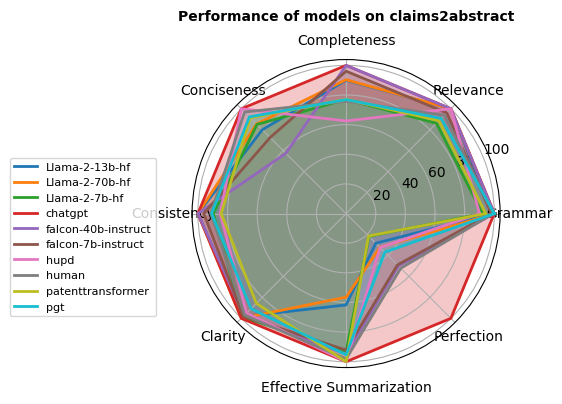

In [4]:
# calculate the ratio of win, lose for each model compared to human and other models
default_ratios = {"win": 0, "lose": 0}
compared_to_human = defaultdict(lambda: default_ratios.copy())
compared_to_models = defaultdict(lambda: default_ratios.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    if "orig" in [model1, model2]:
        if model1 == "orig":
            if annot["preference"] == "draw":
                # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
                if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 2:
                    compared_to_human[model2]["win"] += 1
                else:
                    compared_to_human[model2]["lose"] += 1

            elif annot["preference"] == "left":
                compared_to_human[model2]["lose"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model2]["win"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
        elif model2 == "orig":
            if annot["preference"] == "draw":
                # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
                if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 2:
                    compared_to_human[model1]["win"] += 1
                else:
                    compared_to_human[model1]["lose"] += 1
            elif annot["preference"] == "left":
                compared_to_human[model1]["win"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model1]["lose"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
    else:
        if annot["preference"] == "draw":
            # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
            if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 2:
                compared_to_models[model1]["win"] += 1
                compared_to_models[model2]["win"] += 1
            else:
                compared_to_models[model1]["lose"] += 1
                compared_to_models[model2]["lose"] += 1

        elif annot["preference"] == "left":
            compared_to_models[model1]["win"] += 1
            compared_to_models[model2]["lose"] += 1
        elif annot["preference"] == "right":
            compared_to_models[model1]["lose"] += 1
            compared_to_models[model2]["win"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))


# Iterate through the errors data and calculate the complement (1 - error rate) for each error type except "Correct"
for i, (model, error_freq) in enumerate(errors):
    for error_type in error_freq:
        if error_type != "Correct":
            errors[i][1][error_type] = 1 - error_freq[error_type]

############################################################################################################
import matplotlib.pyplot as plt
import numpy as np

error_type_mapping = {
    "Grammar Errors": "Grammar",
    "Irrelevant Content": "Relevance",
    "Incomplete Coverage": "Completeness",
    "Overly Wordy or Lengthy": "Conciseness",
    "Contradictory Information": "Consistency",
    "Unclarity": "Clarity",
    # "Other": "Effective Summarization",
    "Ineffective Summarization": "Effective Summarization",
    "Correct": "Perfection"  # Renamed to "Perfection"
}

# Iterate through the errors data and update error type names
for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = {}
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] = freq
    errors[i] = (model, updated_error_freq)

errors = [(model, {error: round(freq * 100, 2) for error, freq in error_freq.items()}) for model, error_freq in errors]

# Define the error types
error_types = ["Grammar", "Relevance", "Completeness", "Conciseness", "Consistency", "Clarity", "Effective Summarization", "Perfection"]

# Calculate the number of variables we're plotting.
num_vars = len(error_types)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
angles += angles[:1]

# Draw one axe per variable and add labels
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

# Helper function to draw one model on the chart.
def draw_model(ax, angles, model_name, stats):
    # Plot data and fill with color
    stats += stats[:1]  # Complete the loop
    ax.plot(angles, stats, label=model_name, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Iterate through each model
for model, error_freq in errors:
    stats = [error_freq.get(error, 0) for error in error_types]
    draw_model(ax, angles, model, stats)

# Add attribute labels
ax.set_thetagrids(np.degrees(angles[:-1]), error_types, fontsize=10)

# Set the title of the chart
plt.title('Performance of models on claims2abstract', fontsize=10, y=1.1, fontweight='bold')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.7), fontsize=8)

# Show plot
plt.savefig('./figures/c2a_error_polar', dpi=300)


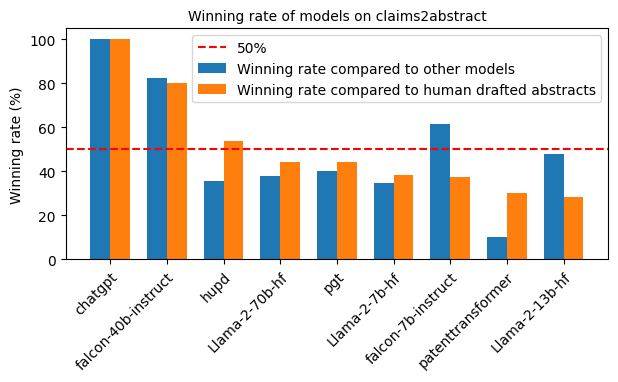

In [5]:
# visualize bar plots of choices_with_models (blue) and choices_with_orig (orange) for each model next to each other
import matplotlib.pyplot as plt
import numpy as np


# fix size of the plot
plt.figure(figsize=(7, 3))  # Adjust the figure size as needed

# sort the model names by the percentage of winning rate
compared_to_human = {k:v for k,v in sorted(compared_to_human.items(), key=lambda x: x[1]["win"] / (x[1]["win"] + x[1]["lose"]), reverse=True) if k!="orig"}
# sort the model names by the percentage of winning rate in compared_to_humans
compared_to_models = {model: compared_to_models[model] for model, _ in compared_to_human.items() if model != "orig"}


model_names1, freqs_models = compared_to_models.keys(), compared_to_models.values()
model_names2, freqs_orig = compared_to_human.keys(), compared_to_human.values()

assert model_names1 == model_names2
freqs_models = [l["win"] / (l["win"] + l["lose"]) * 100 for l in freqs_models]
freqs_orig = [l["win"] / (l["win"] + l["lose"]) * 100 for l in freqs_orig]


width = 0.35  # Width of the bars
bar_positions_models = np.arange(len(model_names1))
bar_positions_orig = bar_positions_models + width  # Shift the positions for the second set of bars

plt.bar(bar_positions_models, freqs_models, width=width, label="Winning rate compared to other models")
plt.bar(bar_positions_orig, freqs_orig, width=width, label="Winning rate compared to human drafted abstracts")

# add red line to 50% for reference
plt.axhline(y=50, color='r', linestyle='--', label="50%")


plt.xticks(bar_positions_models + width / 2, model_names1, rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Winning rate (%)")
plt.title("Winning rate of models on claims2abstract", fontsize=10)
plt.legend()

plt.savefig('./figures/c2a_win_percent', dpi=300)